In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/MyDrive/dm_dataset/
!pip install pandas==1.3.4

Mounted at /content/drive
country_codes.csv	 model_nn.pkl
female_players.csv	 model_nn_scaled.h5
height_dataset.csv	 model_nn_weights.h5
male_players.csv	 model_rf_no_toruney.pkl
matches.pkl		 model_rf.pkl
matches_tounery_id.pkl	 model_rule.pkl
model_ada.pkl		 model_svm.pkl
model_config.json	 nn
model_dt_no_tourney.pkl  players_dt_for_classification_nt.pkl
model_dt.pkl		 players_dt_for_classification.pkl
model_gaussian_nb.pkl	 players_for_classification.pkl
model_knn.pkl		 players.pkl
model_mnb.pkl		 players_scaled_for_classification.pkl
model_nn1.h5		 players_tourney_importance.pkl
model_nn.h5		 tennis_matches.csv
     |████████████████████████████████| 11.3 MB 7.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency con

# Load Player Pickle

In [ ]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats.stats import pearsonr
from sklearn.metrics import silhouette_score
import seaborn as sns

players = pd.read_pickle('drive/MyDrive/dm_dataset/players_tourney_importance.pkl') #loading the dataframe for Player Profile

# Players Dataset Overview

Some statistics for the player dataframe.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


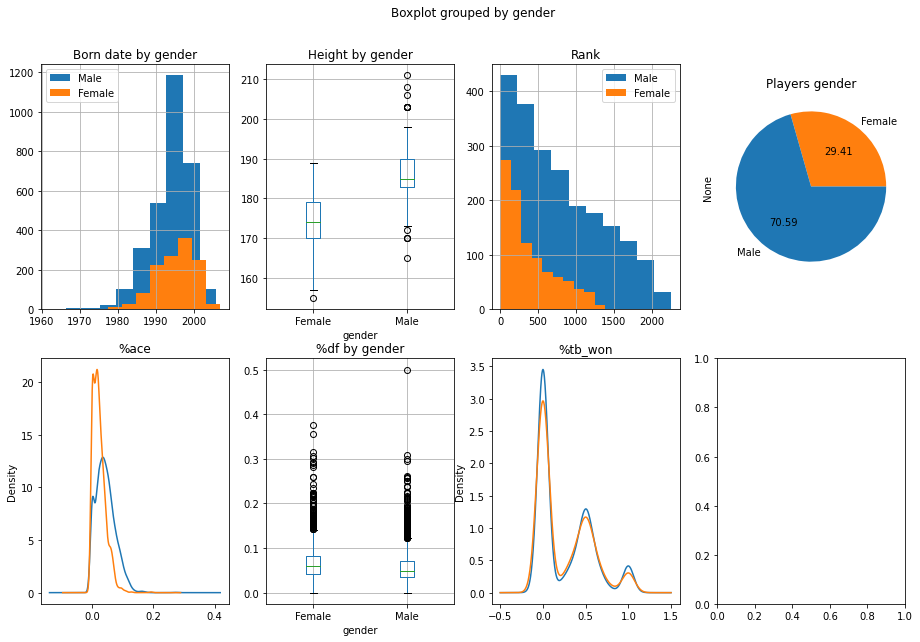

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(15,10))
players[players.gender=='Male'].born_date.hist(ax=ax[0][0],label='Male')
players[players.gender=='Female'].born_date.hist(ax=ax[0][0], label='Female')
ax[0][0].legend(loc="upper left")
ax[0][0].set_title("Born date by gender")
players.boxplot(column=['ht'], ax=ax[0][1],by='gender')
ax[0][1].set_title("Height by gender")
players[players.gender=='Male']['rank'].hist(ax=ax[0][2],label='Male')
players[players.gender=='Female']['rank'].hist(ax=ax[0][2], label='Female')
ax[0][2].set_title("Rank")
ax[0][2].legend(loc="upper right")
players.boxplot(column=['%df'], ax=ax[1][1],by='gender')
ax[1][1].set_title("%df by gender")

players[players.gender=='Male']['%ace'].plot.kde(ax=ax[1][0],label='Male')
players[players.gender=='Female']['%ace'].plot.kde(ax=ax[1][0], label='Female')
ax[1][0].set_title("%ace")

players[players.gender=='Male']['%tb_won'].plot.kde(ax=ax[1][2],label='Male')
players[players.gender=='Female']['%tb_won'].plot.kde(ax=ax[1][2], label='Female')
ax[1][2].set_title("%tb_won")

players.groupby('gender').size().plot(kind='pie', autopct='%.2f',title='Players gender', ax=ax[0][3], colors = ['tab:orange', 'tab:blue'])


plt.show()

In [ ]:
corr_matrix = players.corr() #compute the correlation matrix
corr_matrix.style.background_gradient(cmap='coolwarm') #plot the correlation

,born_date,ht,rank,o_rank,tourney_importance,mean_tourney_importance,%w_clay,%w_hard,%w_grass,%w_carpet,%wins,%fsw,%ssw,%ace,%df,gpm,%tb_won,%bp_saved,%succ1serve,%1st_srp_won,%2nd_srp_won,%bp_won,minutes_x_match
born_date,1.000000,-0.128055,0.219117,0.106872,-0.197180,0.007492,-0.174478,-0.199913,-0.185733,-0.033568,-0.202305,-0.200910,-0.111063,-0.193069,0.119113,-0.140047,-0.156234,-0.153472,-0.087875,-0.037944,-0.084641,-0.057763,-0.086790
ht,-0.128055,1.000000,0.071835,0.078783,0.053306,-0.200387,-0.015711,0.014301,-0.011688,0.040842,0.028382,0.590250,0.272707,0.628405,-0.076548,0.339787,0.034675,0.370024,-0.095988,-0.567484,-0.392945,-0.313946,0.043509
rank,0.219117,0.071835,1.000000,0.658139,-0.555725,-0.386012,-0.553696,-0.557756,-0.485413,-0.022223,-0.580132,-0.290760,-0.256639,-0.164028,0.237232,-0.310585,-0.399998,-0.269114,-0.179325,-0.445448,-0.441553,-0.232042,-0.375251
o_rank,0.106872,0.078783,0.658139,1.000000,-0.381877,-0.314025,-0.412111,-0.388671,-0.345286,-0.015946,-0.420735,-0.242053,-0.173638,-0.173436,0.210789,-0.227370,-0.364153,-0.240042,-0.129533,-0.271814,-0.278297,-0.156838,-0.256692
tourney_importance,-0.197180,0.053306,-0.555725,-0.381877,1.000000,0.403178,0.578626,0.538245,0.733475,0.025899,0.516778,0.319378,0.240771,0.270495,-0.208755,0.303852,0.370297,0.274863,0.132990,0.209986,0.262051,0.110929,0.307736
mean_tourney_importance,0.007492,-0.200387,-0.386012,-0.314025,0.403178,1.000000,0.257505,0.175060,0.378411,-0.027009,0.172451,0.161350,0.114603,0.133540,-0.155908,0.187110,0.207303,0.136506,0.068718,0.098078,0.132925,0.041751,0.186072
%w_clay,-0.174478,-0.015711,-0.553696,-0.412111,0.578626,0.257505,1.000000,0.457914,0.461770,0.013675,0.707513,0.369773,0.322132,0.220448,-0.243761,0.308385,0.443856,0.317916,0.172227,0.399871,0.396863,0.224483,0.345538
%w_hard,-0.199913,0.014301,-0.557756,-0.388671,0.538245,0.175060,0.457914,1.000000,0.476659,0.035522,0.839811,0.472199,0.418149,0.334182,-0.270392,0.337733,0.510600,0.378453,0.192268,0.433061,0.450154,0.270746,0.315041
%w_grass,-0.185733,-0.011688,-0.485413,-0.345286,0.733475,0.378411,0.461770,0.476659,1.000000,0.017059,0.470031,0.275237,0.206805,0.238561,-0.158479,0.270557,0.331767,0.234472,0.121920,0.218614,0.238902,0.107502,0.261779
%w_carpet,-0.033568,0.040842,-0.022223,-0.015946,0.025899,-0.027009,0.013675,0.035522,0.017059,1.000000,0.064458,0.035017,0.027151,0.011758,-0.027178,0.047469,0.030880,0.035463,0.008135,0.025041,0.025600,0.019369,0.026463


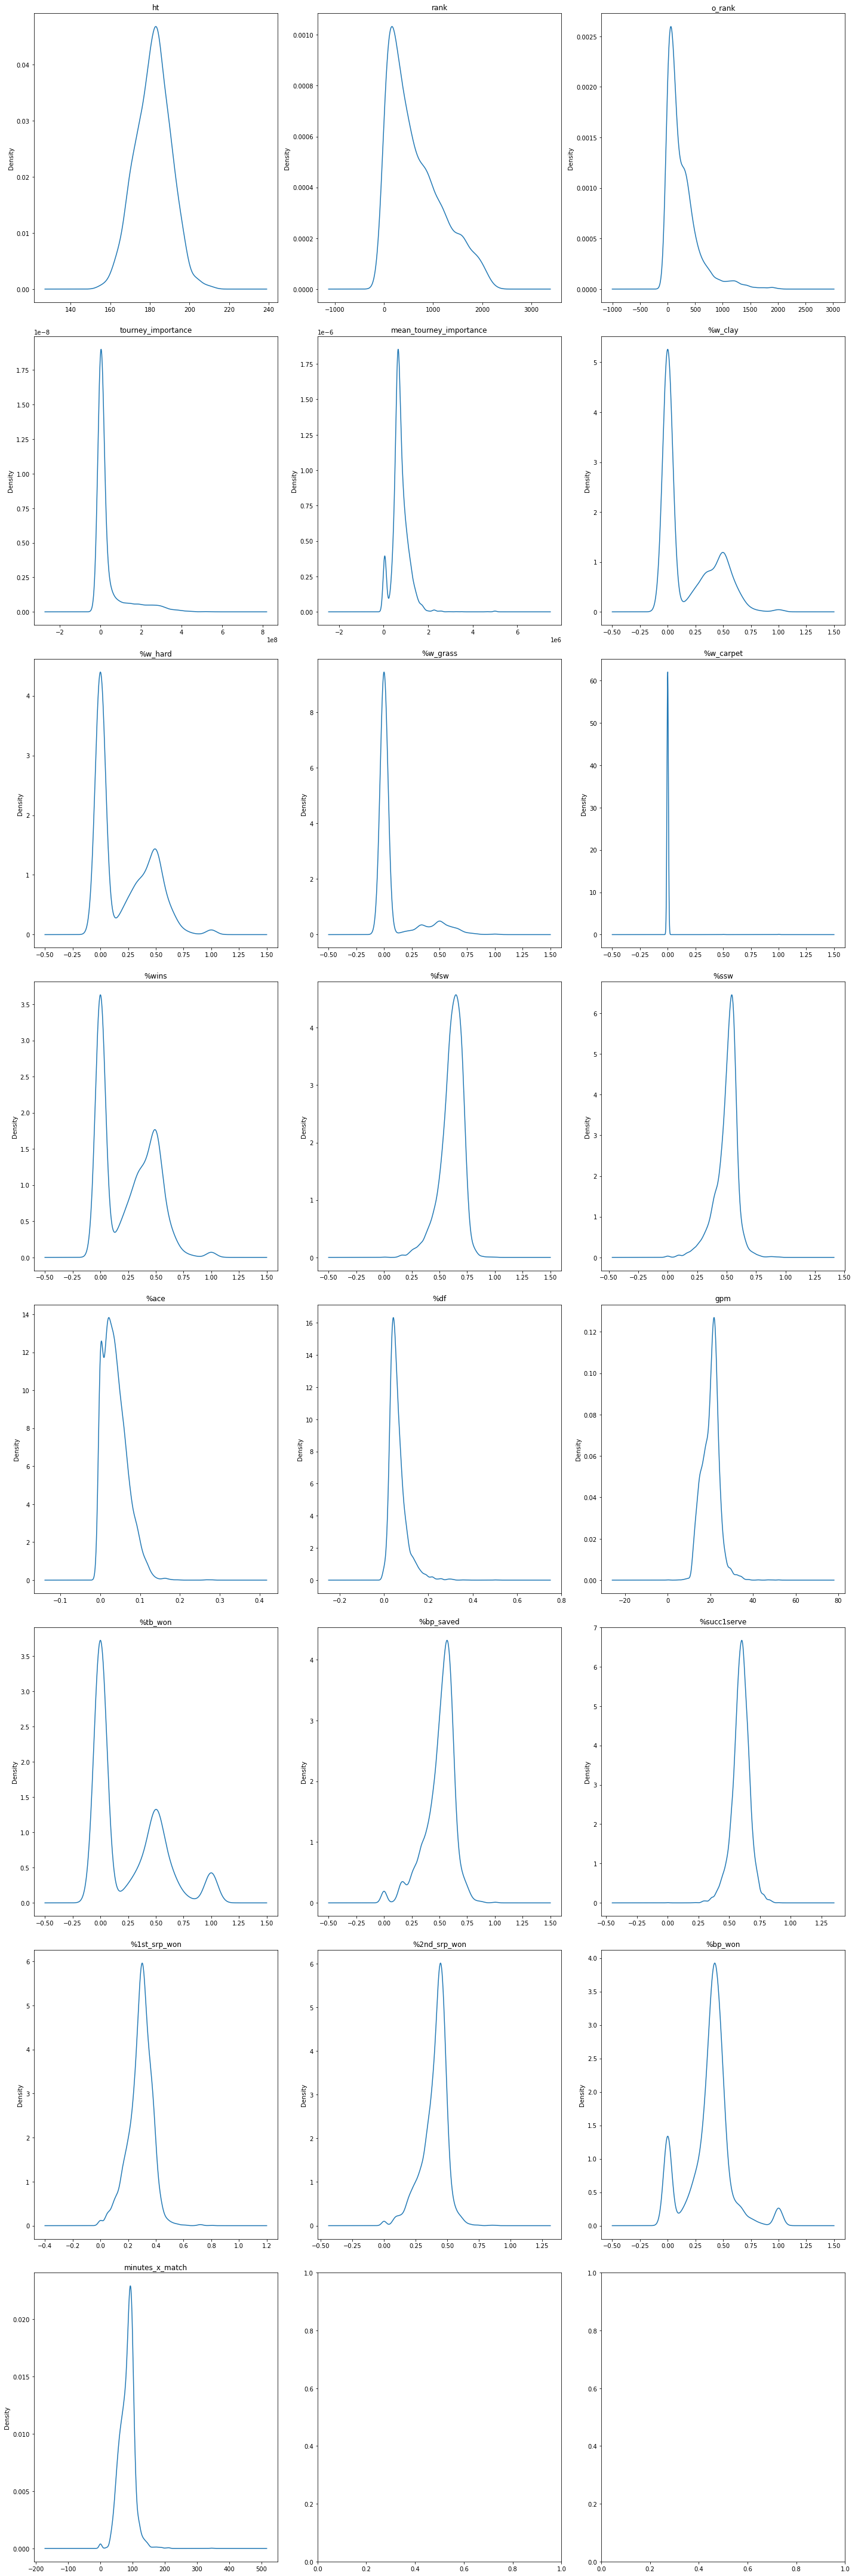

In [ ]:
# Density plot of all the features.
import math
num_cols = players._get_numeric_data().columns[1:]
rows = math.ceil(len(num_cols)/3)
fig, axes = plt.subplots(rows,3, figsize=(20,60))
r=c =0
for col in num_cols:
    players[col].plot(kind='kde', ax=axes[r][c], title=col)
    c+=1
    if c%3==0:
        c=0
        r+=1

fig.tight_layout()
plt.show()

# Selecting features

We have selected 4 features to perform the clustering, in particular we have ignored the categorical attributes as there isn’ta proper metric to define a distance function over them. The used attributes are: 
- rank : the strength of theplayer
- tourney_importance:  the amount of matches played with their importance
- %ace: offensive ability
- %1st_srp_won:defensive ability 

The height has been excluded because only 500 has this information thus the finaldataset for clustering contains 3050 unique players.

In [ ]:
correct_columns = players[:]
correct_columns = correct_columns[(correct_columns['rank'].notna())] #taking columns with rank
correct_columns = correct_columns[(correct_columns['o_rank'].notna())] #taking columns with o_rank
# correct_columns = correct_columns[(correct_columns['ht'].notna())] #taking columns with ht
correct_columns = correct_columns.drop(['gender','id','ioc','hand', 'mean_tourney_importance'],axis=1)
correct_columns = correct_columns[['rank', 'tourney_importance', '%ace','%1st_srp_won']] #selected features 05/12/2021

"""Other possible features combination for clustering analysis"""
# correct_columns = correct_columns[['%tb_won', 'tourney_importance', '%bp_saved','%df']] # old report
# correct_columns = correct_columns[['%tb_won', 'tourney_importance', '%bp_saved','%wins']] # Silhouette 45
# correct_columns = correct_columns[['ht', 'tourney_importance', '%ace','%1st_srp_won']] # prima 05/12/2021
# correct_columns = correct_columns[['tourney_importance', 'ht','%ace','%1st_srp_won']] # Silhouette 32
# correct_columns = correct_columns[['born_date','%ace','%tb_won','tourney_importance']] # pca based Silhouette 46
# correct_columns = correct_columns[['ht','%ace','%1st_srp_won','tourney_importance','minutes_x_match']] # 
# correct_columns = correct_columns[['ht','%ace','%1st_srp_won','tourney_importance','born_date']] # 
# correct_columns = correct_columns[['%tb_won', 'rank', '%bp_saved','%1st_srp_won']] #

corr_matrix = correct_columns.corr() #compute the correlation matrix
corr_matrix.style.background_gradient(cmap='coolwarm') #plot the correlation

,rank,tourney_importance,%ace,%1st_srp_won
rank,1.000000,-0.556388,-0.164412,-0.464810
tourney_importance,-0.556388,1.000000,0.263452,0.192371
%ace,-0.164412,0.263452,1.000000,-0.201896
%1st_srp_won,-0.464810,0.192371,-0.201896,1.000000


Saving the correlation plot of the chosen feature.

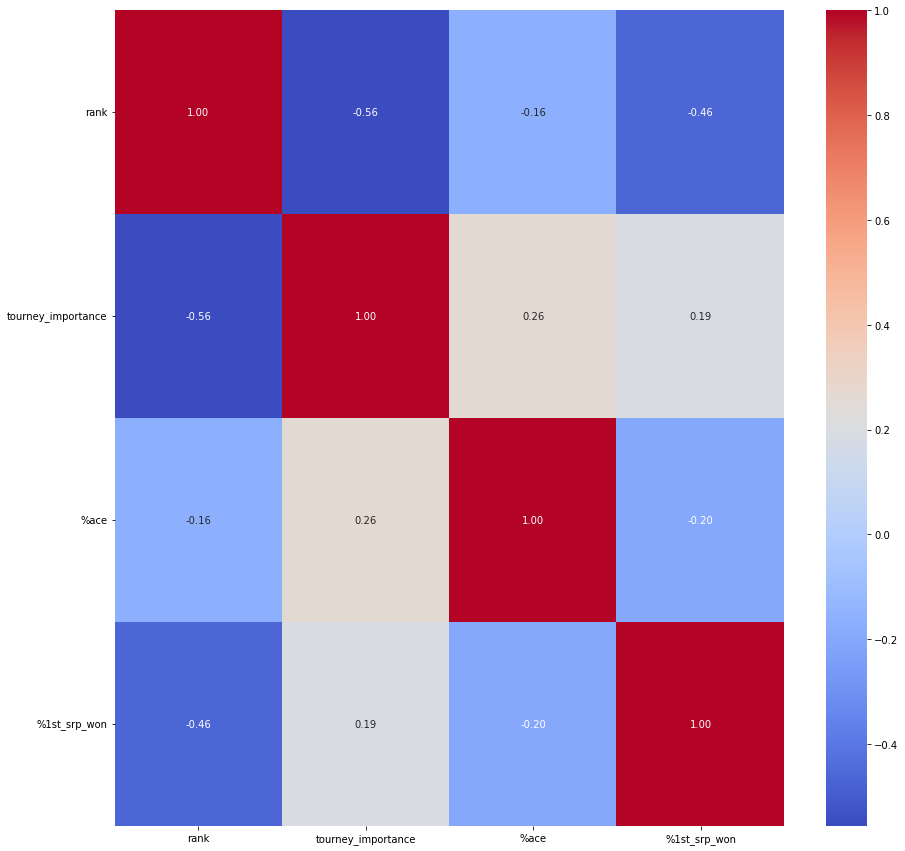

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f',cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

# Normalization

We decided to normalize the values using the MinMax scaler, since we use a lot of percentage values mixed with non percentage, the minmax scaler will trasform them between \[0,1] so we have a better visualizzation on cluster line plots and the other fact is that no attributes that we used follows a Gaussian distribution (so Standard scaler isn’t the best).

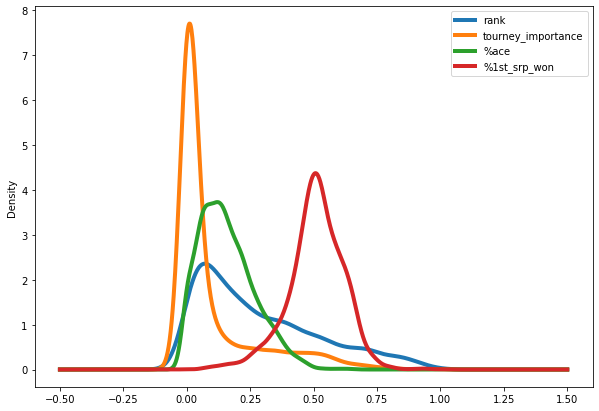

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(correct_columns.values)
pd.DataFrame(data=scaled,columns=correct_columns.columns).plot.density(figsize = (10, 7),
                       linewidth = 4)
plt.show()

# PCA Analysis

We apply PCA analysis mainly to visualize the data but also to see which features capture the most variance. Thanks to the cumulative explained variance we can see that the first 2 component capture more than 80% of the variance. The first component is rank an it took 65% of the variance.

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=fbbb4849058c5d01f22f06a62c8af6e212b9c70fb9c2ef518f118b59a66e8989
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[4]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


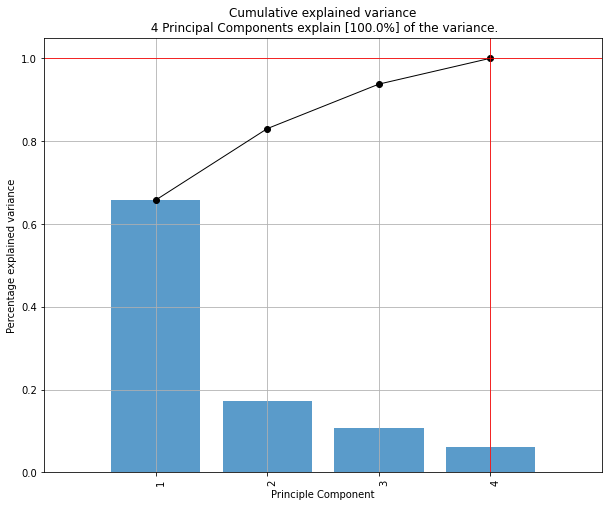

<Figure size 432x288 with 0 Axes>

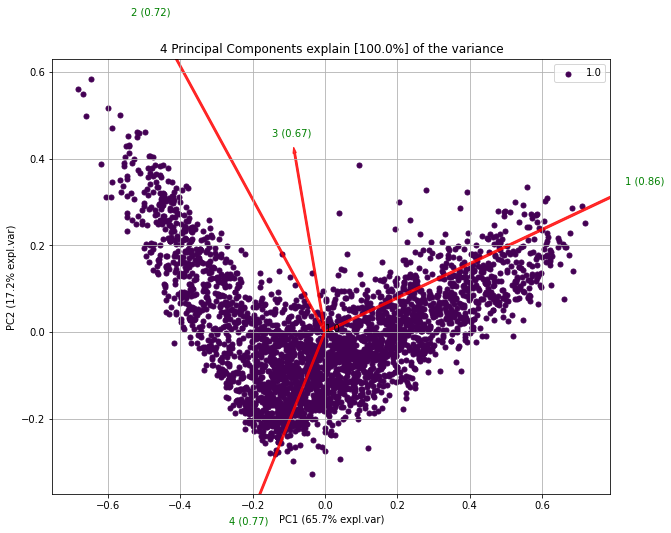

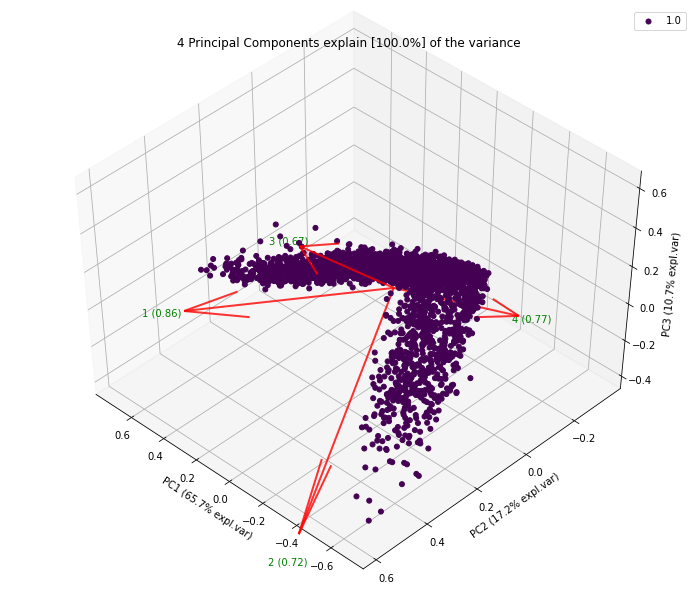

In [ ]:
!pip install pca
from pca import pca
# Initialize to reduce the data up to the number of componentes that explains 95% of the variance.
# model = pca(n_components=0.95)
# Or reduce the data towards 2 PCs
model = pca(n_components=scaled.shape[1])
# Fit transform
results = model.fit_transform(scaled)
# Plot explained variance
fig, ax1 = model.plot()
# Make biplot with the number of features
fig, ax2 = model.biplot(n_feat=21,cmap='viridis')
fig, ax3 = model.biplot3d(n_feat=21,cmap='viridis')

In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA()
principalComponents = pca_model.fit_transform(scaled) #appling the pca trasformation
n_pcs = pca_model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca_model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = list(correct_columns.columns) # get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
# Printing the name of the features sorted by importance
print("The most important features:")
for i in range(n_pcs):
    print(str(most_important_names[i])+" :"+str(pca_model.explained_variance_ratio_[i]))
most_important_vect = [pca_model.components_[i] for i in range(n_pcs)]
# Printing the name of the features sorted by importance
print("The most important features vectors:")
for i in range(n_pcs):
    print(str(most_important_vect[i]) + ' : ' + str(pca_model.explained_variance_ratio_[i]))

The most important features:
rank :0.6575393048888851
tourney_importance :0.172583241421022
%ace :0.10743569799229541
%1st_srp_won :0.062441755697797675
The most important features vectors:
[ 0.85584196 -0.46696132 -0.09027182 -0.20330435] : 0.6575393048888851
[ 0.33687835  0.71528181  0.44379847 -0.42181493] : 0.172583241421022
[-0.31492578 -0.51949756  0.66833284 -0.42927295] : 0.10743569799229541
[ 0.2342419  -0.02100834  0.59010604  0.77231098] : 0.062441755697797675


# Clustering functions

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm
def plot_silhouette_score(df, labels):
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    
    silhouette_vals = silhouette_samples(df, labels)

    y_ax_lower, y_ax_upper = 0, 0
    y_tick = []

    for i, c in enumerate(cluster_labels):
    
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
    
        print('Cluster', c, 'avg silhouette:', np.mean(c_silhouette_vals))
    
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        y_tick.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    print('Total avg silhouette:', silhouette_avg)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.yticks=(y_tick, cluster_labels + 1)
    plt.ylabel('Points')
    plt.xlabel('Silhouette')
    plt.tight_layout()

from sklearn.metrics.pairwise import euclidean_distances
def plot_similarity_heatmap(df, labels):
    df = pd.DataFrame(df)
    df['cluster'] = labels
    columns = df.columns[0:-1]
    df.sort_values(by='cluster', ascending=False, inplace=True)
    dist = euclidean_distances(df.loc[:, columns], df.loc[:, columns])
    sim = np.exp(-dist)
    fig, ax = plt.subplots(figsize=(7,5))
    sns.heatmap(sim, ax=ax)

def plot_basic_statistics(df, labels, columns):
    df = pd.DataFrame(df, columns=columns)
    df['cluster'] = labels
    columns = df.columns[0:-1]     
    means = []
    std = []
    for i in np.unique(df['cluster'].array):
        clust = df.loc[df['cluster'] == i, columns]
        means.append(clust.describe().loc['mean'].values)
        std.append(clust.describe().loc['std'].values)  
    legend = []
    plt.figure(figsize=(20,5))
    for i in np.unique(df['cluster'].array):       
        fig = plt.plot(range(0, columns.shape[0]), kmeans.cluster_centers_[i], marker='o')
        legend.append('Cluster %d' %i)
    plt.legend(legend)
    plt.xticks(range(0, columns.shape[0]), columns)

# K-means

We tried different values for k between 2 and 20 by plotting the the SSE value and silhouettescore. For each try is selected the best among 10 runs (with the low-est SSE) and with a maximum of 300 iterations of the K-Means algorithm.

Using the elbow method the best value for k is 3 as it represent a good trade-off between SSE and silhouette score.

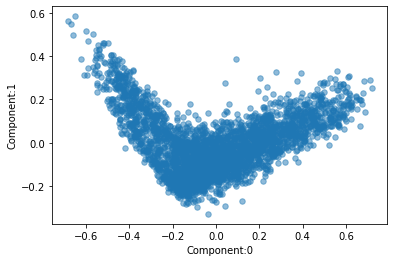

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


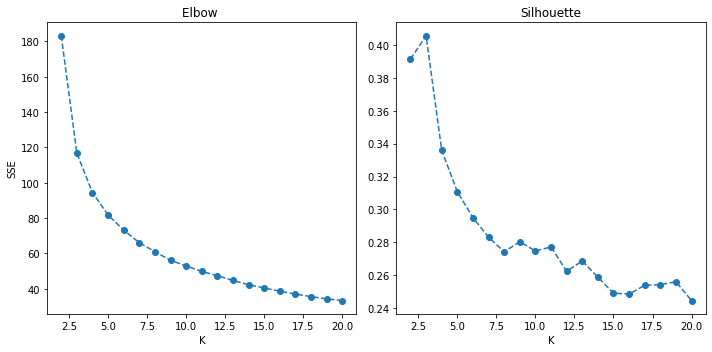

Cluster 0 avg silhouette: 0.42011832171296665
Cluster 1 avg silhouette: 0.35353345500050837
Cluster 2 avg silhouette: 0.4484668991182747
Total avg silhouette: 0.4058242329584568
Clusters labels: [0 1 2]
Elements per cluster: [1651  877  522]


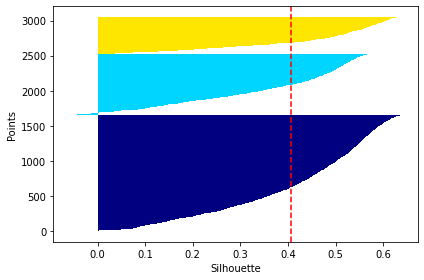

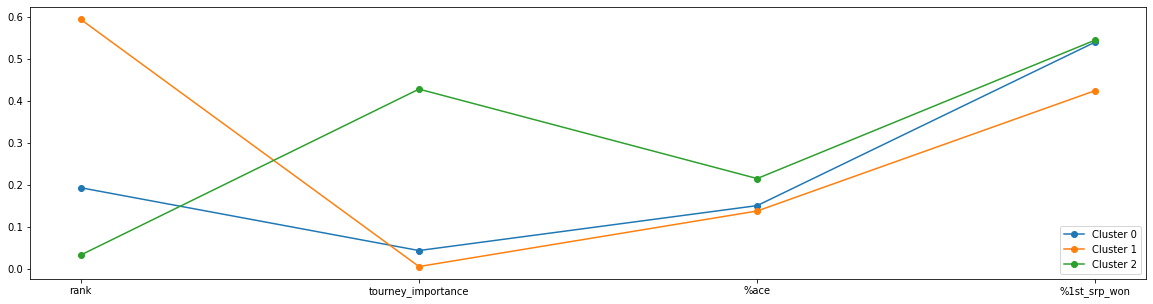

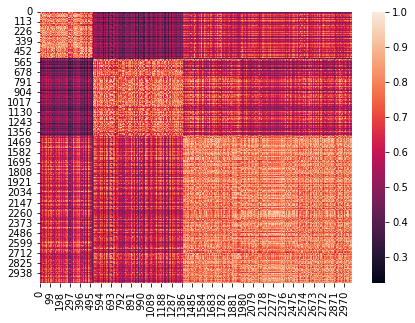

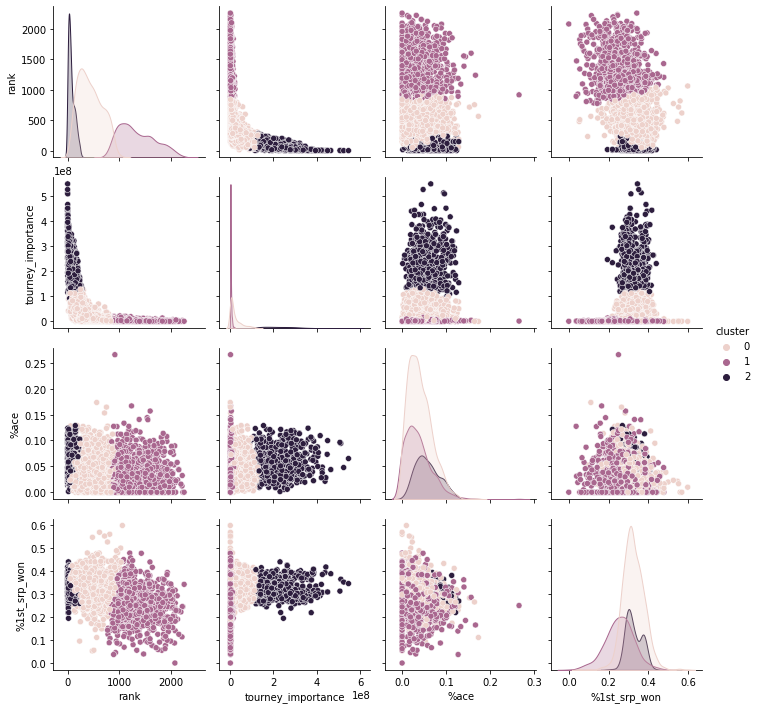

In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA()
principalComponents = pca_model.fit_transform(scaled) #appling the pca trasformation
num_components = pca_model.components_.shape[0]
principalDf = pd.DataFrame(data = principalComponents, columns = ["Component:"+str(i) for i in range(num_components)])
principalDf.plot.scatter(x=0,y=1, s = 30, colormap='viridis', alpha = 0.5)
plt.show()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

sse_list = list()
silhouette_list = list()
max_k = 20
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    label = kmeans.fit_predict(scaled)
    sse = kmeans.inertia_
    sse_list.append(sse)
    silhouette_list.append(silhouette_score(scaled, label))
    print(k)
    
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(range(2,max_k+1),sse_list,marker='o', linestyle='--')
axes[1].plot(range(2,max_k+1),silhouette_list,marker='o', linestyle='--')
axes[0].title.set_text("Elbow ")
axes[1].title.set_text("Silhouette")
axes[1].set_xlabel('K')
axes[0].set_xlabel('K')
axes[0].set_ylabel('SSE')
fig.tight_layout()
plt.show()
kmeans = KMeans(init='k-means++', n_clusters=3)
clusters_profiles = kmeans.fit_predict(scaled)
plot_silhouette_score(scaled, clusters_profiles)
plot_basic_statistics(scaled, clusters_profiles, correct_columns.columns)
plot_similarity_heatmap(scaled, clusters_profiles)
scaled_with_label = correct_columns.copy()
scaled_with_label['cluster'] = kmeans.labels_ 
sns.pairplot(scaled_with_label, hue='cluster', diag_kind='kde');
results = np.unique(clusters_profiles, return_counts=True)
print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")

In [ ]:
players_wthcluster = correct_columns.copy()
players_wthcluster['cluster'] = clusters_profiles

In [ ]:
players_wthcluster.groupby('cluster').mean().reset_index()

,cluster,rank,tourney_importance,%ace,%1st_srp_won
0,0,436.327075,2.353826e+07,0.039931,0.323639
1,1,1343.218928,2.649880e+06,0.036513,0.254270
2,2,74.072797,2.342717e+08,0.057094,0.326489


Now we visualize the the clusters with the 2 principal compoment from PCA. We can see that the left part are the stongest player the central the medium and the right part the weaker one.

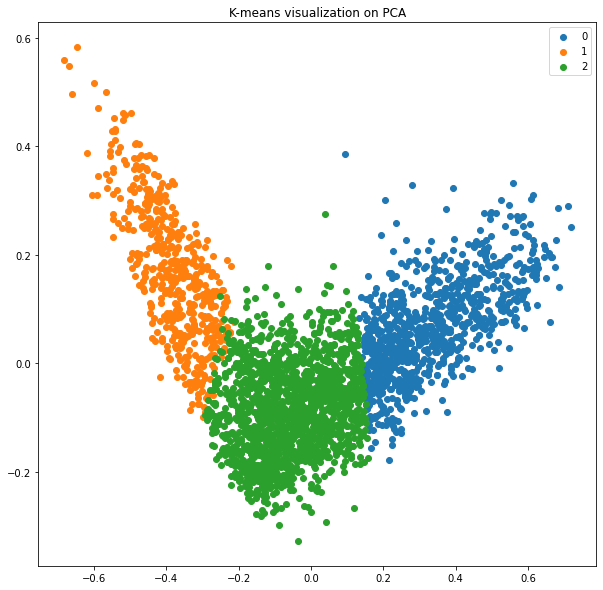

In [ ]:
# Visualizing the cluster.
label = kmeans.fit_predict(scaled)
centers = np.array(kmeans.cluster_centers_)
plt.figure(figsize=(10,10))
uniq = np.unique(label)
centers = np.array(centers)
for (index, i) in enumerate(uniq):
   plt.scatter(principalComponents[label == i, 0] , principalComponents[label == i, 1] , label = i)
#This is done to find the centroid for each clusters.
plt.title("K-means visualization on PCA")
plt.legend()
plt.show()

Line plot with all the features, this confirm the fact that the cluster really capture the skills of the players and cluster them in strong medium and high.

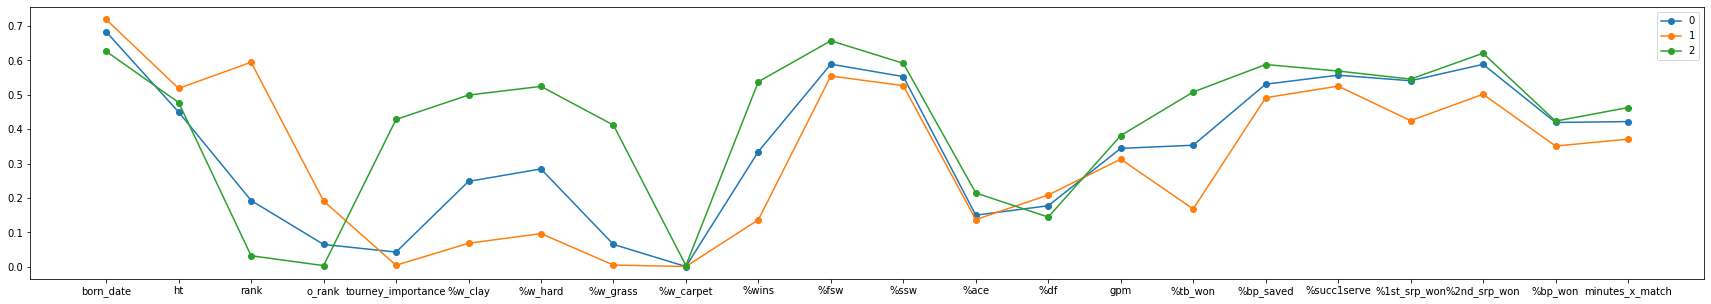

In [ ]:
global_lineplot = players[:]
global_lineplot = global_lineplot[(global_lineplot['rank'].notna())] #taking columns with rank
global_lineplot = global_lineplot[(global_lineplot['o_rank'].notna())] #taking columns with o_rank
global_lineplot = global_lineplot.drop(['gender','id','ioc','hand', 'mean_tourney_importance'],axis=1)
global_lineplot = global_lineplot.fit_transform(global_lineplot.values)
global_lineplot = pd.DataFrame(global_lineplot, columns=global_lineplot.columns)
global_lineplot['cluster'] = clusters_profiles
ax = global_lineplot.groupby('cluster').mean().reset_index().iloc[:, 1:].transpose().plot(figsize=(30,5),marker='o')
ax.set_xticks(range(0, global_lineplot.columns[:-1].shape[0]))
ax.set_xticklabels(global_lineplot.columns[:-1])
plt.show()

As it can be seen in above the k-means captures three clusters each representingthe strength of the players (Strong, Medium, Weak):
- Cluster 2 (Strong players):they are older in age and possess an average height. they have the high rank and play against equally strong players in fact the tourney_importance is high and the win percentage on all terrains is high as well as the winpercentage. It is important to note the high tie break value which indicates concentration and to be decisive in the part with the greatest psychological pressure of the game. Regarding the game characteristics they are really strong in attack as seen in fsw, ssw, ace and have a low percentage of double faults so they make little mistakes during the serve. They have as many excellent characteristics in the defense phaseas we can see in %bp_saved, %1st_srp_won, %2nd_srp_won. While with regard to the duration of the matches we see how the minutes per match are the highest as well as the games per match to indicate that the matches are played by high-level athletes.
- Cluster 1 (Weak players): they are the youngest and also the highest players, have a very low rank and play with much stronger opponents than them. The importance of matches played is low as well as the win percentage and the percentage for each type of terrain. Regarding the game characteristics, both in attack and defense are weak, we see in particular how the percentage of double faults is high and how the percentage of %tb_won is low, indicating young and inexperienced players who cannot manage the decisive part of the game well. Regarding the duration of the match, the minutes per match are really low as well as the games per match supported by the fact that the match is not fought also justified by the fact that the opponents are stronger.
- Cluster 0 (Medium players): they are players with an average age but with a low height let’s see how their rank is in the average and they play with players of the same level. Regarding the percentages of victories they turn out to be exactly between the strong and the weak.  We can say that in all the features they are found in the middle especially in %tb_won, gpm, minutes per match. While regarding the characteristics during the game, in the attack phase they are not strong as we cansee from the graph in fact they are very close to the performance of cluster 1 aswe can see in the ace percentage, but in the defense phase they are really strong as we can see in succ1srtve, %1st_srp_won, %2nd_srp_won %bp_won they really are similar to the strongest if not the same in some places. So this cluster could represent those players with average experience who are strong on defense but need to improve on offense to be complete and therefore consider them strong.

# DBSCAN

We first use the Knee method with different k in order to find the areas where the distance for the neighborhood increase.

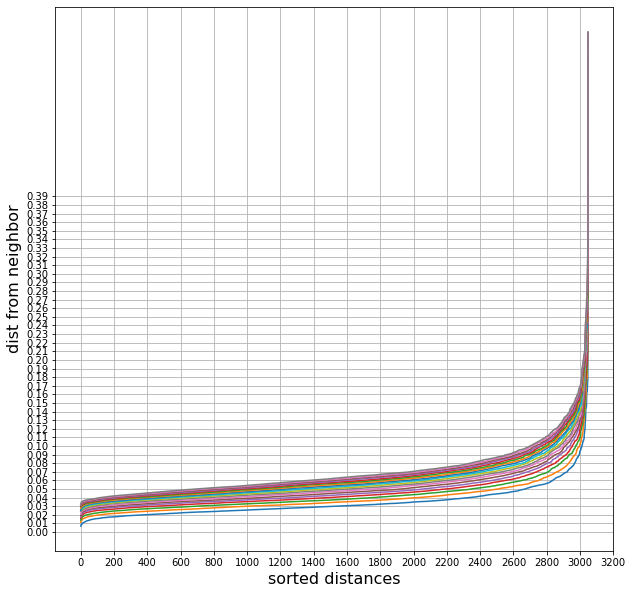

In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
dist = pdist(scaled, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist
k_list = [i for i in range(2,20)]
list_of_list = []
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for i in k_list:
  k = i
  kth_distances = list()
  for d in dist:
      index_kth_distance = np.argsort(d)[k]
      kth_distances.append(d[index_kth_distance])
  plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from neighbor', fontsize=16)
plt.xlabel('sorted distances', fontsize=16)
ax.set_xticks(np.arange(0, 3400, 200))
ax.set_yticks(np.arange(0, 0.4, 0.01))
plt.grid()
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

We perform a grid search in order to find the best hyperparameter epsilon and minsamples.

### Grid search

In [ ]:
# func to get metrics to evaluate the clustering done with certain eps and min_samples
def get_metrics(eps, ms, dataset, iter_):
    # Fitting
    dbscan = DBSCAN(eps=eps, min_samples=ms)
    dbscan.fit(dataset)
    # Mean Noise Point Distance metric
    noise_indices = (dbscan.labels_ == -1)  #list of booleans
    if True in noise_indices:
        nbrs = NearestNeighbors(n_neighbors = 10).fit(dataset)
        distances, _ = nbrs.kneighbors(dataset)   #returns indices of and distances to the neighbors of each point
        noise_distances = distances[noise_indices, 1 : ]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
    # silhouette score
    sil = silhouette_score(dataset, dbscan.labels_)
    # Number of found Clusters metric
    number_of_clusters = len(np.unique(dbscan.labels_[dbscan.labels_ >= 0]))
    return noise_mean_distance, number_of_clusters, sil

In [ ]:
#gs_eps_list = [round(eps, 3) for eps in np.arange(0.06, 0.08, 0.002)]
#gs_ms_list = range(2, 15, 1) # after k=9 we always get 1 cluster

gs_eps_list = [round(eps, 3) for eps in np.arange(0.07, 0.14, 0.005)]
gs_ms_list = range(2, 15, 1) # after k=9 we always get 1 cluster

print("Grid search parameters:")
print("eps:", gs_eps_list)
print("min_samples:", list(gs_ms_list))

results_noise = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

# Dataframe for the metric on the number of clusters
results_clusters = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

# Dataframe to store the silhouette score for each combo in the grid search
results_silhouette = pd.DataFrame(
    data = np.zeros((len(gs_eps_list), len(gs_ms_list))),
    columns = gs_ms_list,
    index = gs_eps_list
)

Grid search parameters:
eps: [0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14]
min_samples: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [ ]:
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
i = 0
for eps in tqdm(gs_eps_list, total=len(gs_eps_list), desc='Proceeding of grid search'):
    for ms in gs_ms_list:
        i += 1
        # Compute metrics
        noise_metric, clusters_metric, sil_metric = get_metrics(eps, ms, scaled, i)
        # Insert results in the apposite dataframes
        results_noise.loc[eps, ms] = noise_metric
        results_clusters.loc[eps, ms] = clusters_metric
        results_silhouette.loc[eps, ms] = sil_metric

Proceeding of grid search:   0%|          | 0/15 [00:00<?, ?it/s]

We display 3 heatmap containing:
- the Mean Noise point Distance
- Number of clusters
- Silhuette score

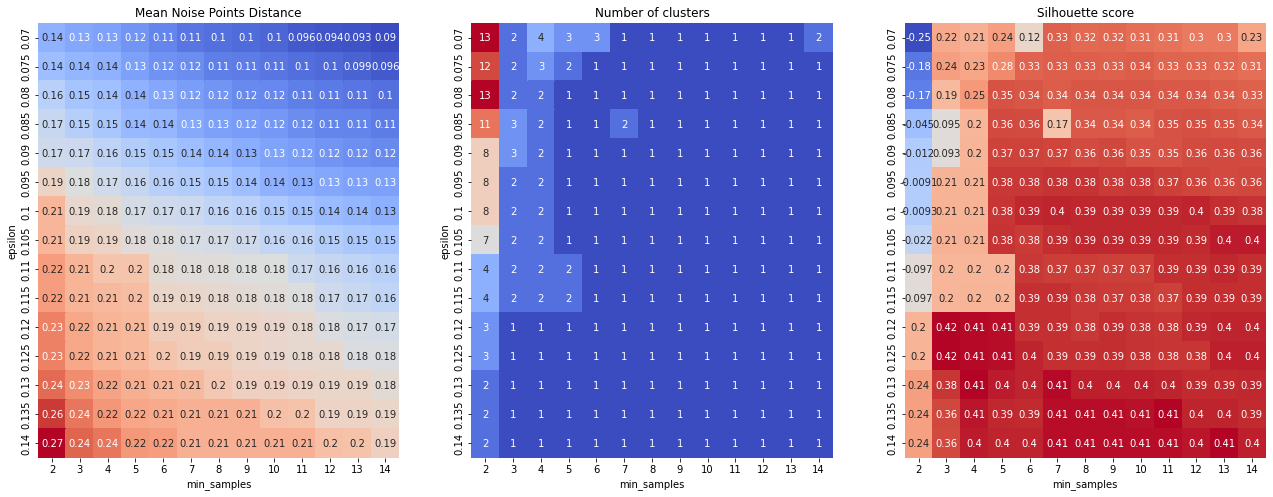

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22,8))
sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False,cmap='coolwarm').set_title("Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False,cmap='coolwarm').set_title("Number of clusters")
sns.heatmap(results_silhouette, annot=True, ax=ax3, cbar=False,cmap='coolwarm').set_title("Silhouette score")
ax1.set_xlabel("min_samples")
ax2.set_xlabel("min_samples")
ax3.set_xlabel("min_samples")
ax1.set_ylabel("epsilon")
ax2.set_ylabel("epsilon")
ax2.set_ylabel("epsilon")
fig.savefig('dbscan_heatmaps.png')
plt.show()

From the plot above we can chose the best hyperparameter by finding the epsilon and min_samples that maximize the silhouette score and also the mean noise point distance. The best value for eps is 0.12 with min samples 3.

Clusters labels: [-1  0]
Elements per cluster: [  14 3036]
Silhouette score:  0.41565251934053626


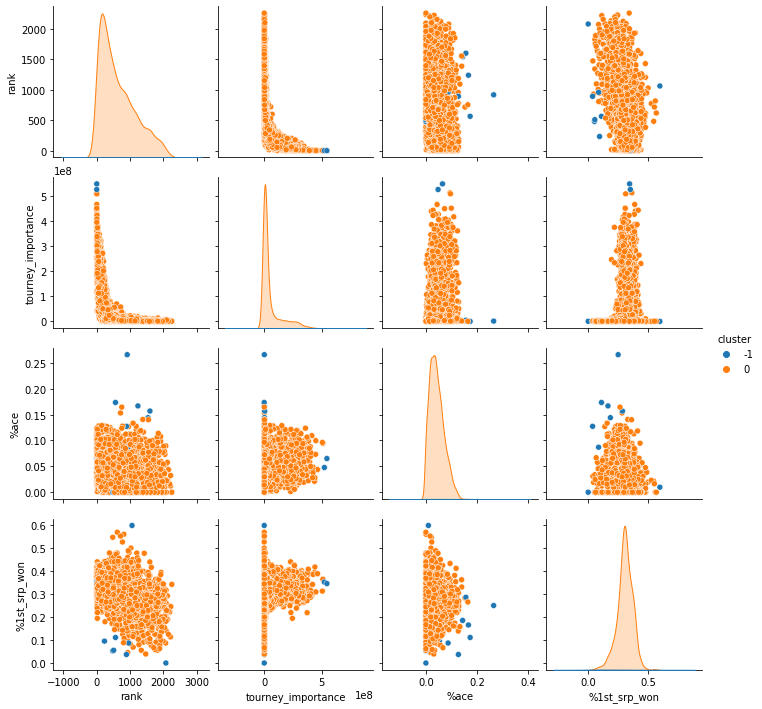

In [ ]:
dbscan = DBSCAN(eps=0.12, min_samples=3).fit(scaled)
results = np.unique(dbscan.labels_, return_counts=True)
print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")

# Silhouette score
print("Silhouette score: ", silhouette_score(scaled, dbscan.labels_))

df_dbscan = correct_columns.copy()
# Extracting labels
df_dbscan['cluster'] = dbscan.labels_

# Pairplot
sns.pairplot(df_dbscan, hue='cluster', palette='tab10')
plt.show()

In [ ]:
dbscan_scaled = pd.DataFrame(scaled, columns=correct_columns.columns[:-1])
dbscan_scaled['cluster'] = dbscan.labels_
dbscan_centroids = dbscan_scaled.groupby('cluster').mean().reset_index()

In [ ]:
dbscan_centroids.iloc[:, 1:].transpose()

,0,1
rank,0.381712,0.280607
tourney_importance,0.141745,0.097810
%ace,0.348430,0.156806
%1st_srp_won,0.312931,0.509454


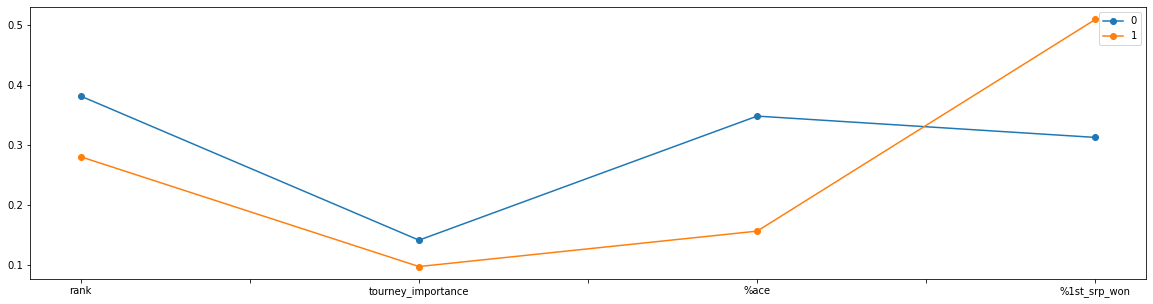

In [ ]:
dbscan_centroids.iloc[:, 1:].transpose().plot(figsize=(20,5),marker='o')
# plt.legend(np.sort(dbscan_scaled['cluster'].unique()));

The results obtained by the DBSCAN algorithm lead to having a single cluster comprising most of the points and the cluster containing the noise points. Due to the distribution of points in space, the density algorithm is not the best for performing clustering analysis. The line plot above does not provide an exhaustive explanation of the clusters so it is difficult to understand.

Cluster -1 avg silhouette: -0.09481751687936316
Cluster 0 avg silhouette: 0.4180064654891129
Total avg silhouette: 0.41565251934053626


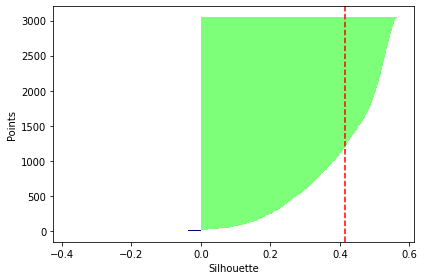

In [ ]:
plot_silhouette_score(scaled,dbscan.labels_)

In [ ]:
df_dbscan[df_dbscan['cluster']==-1]

,rank,tourney_importance,%ace,%1st_srp_won,cluster
187,1061.0,1.951908e+05,0.009709,0.598131,-1
232,233.0,5.704041e+05,0.052632,0.095238,-1
1459,1.0,5.242708e+08,0.047694,0.351973,-1
1509,1.0,5.466240e+08,0.065063,0.345542,-1
1520,2078.0,6.148643e+05,0.000000,0.000000,-1
1543,1238.0,1.465596e+06,0.166667,0.165354,-1
1633,916.0,1.350760e+06,0.265625,0.250000,-1
1700,479.0,1.039687e+06,0.000000,0.052632,-1
2028,509.0,4.663149e+05,0.000000,0.055556,-1
2184,564.0,8.113098e+04,0.173333,0.111111,-1


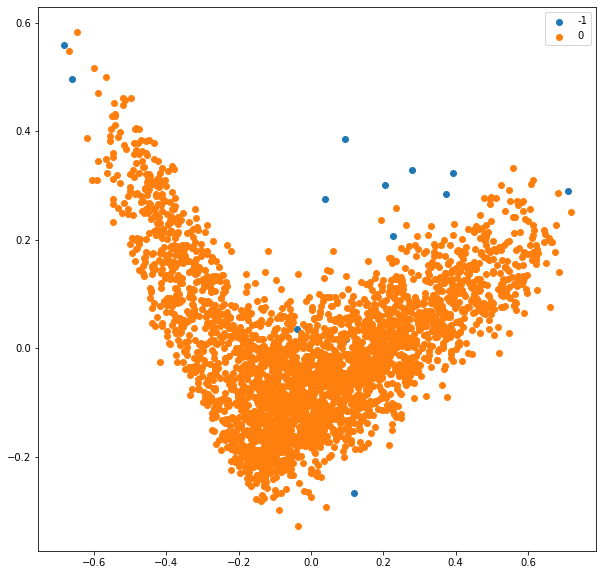

In [ ]:
# label = clusters_profiles
label = dbscan.labels_
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(principalComponents[label == i, 0] , principalComponents[label == i, 1] , label = i)
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()

# Hyerarchical

For the Hierarchical clustering we tried different linkages methods:
- Single
- Complete
- Average
- Ward

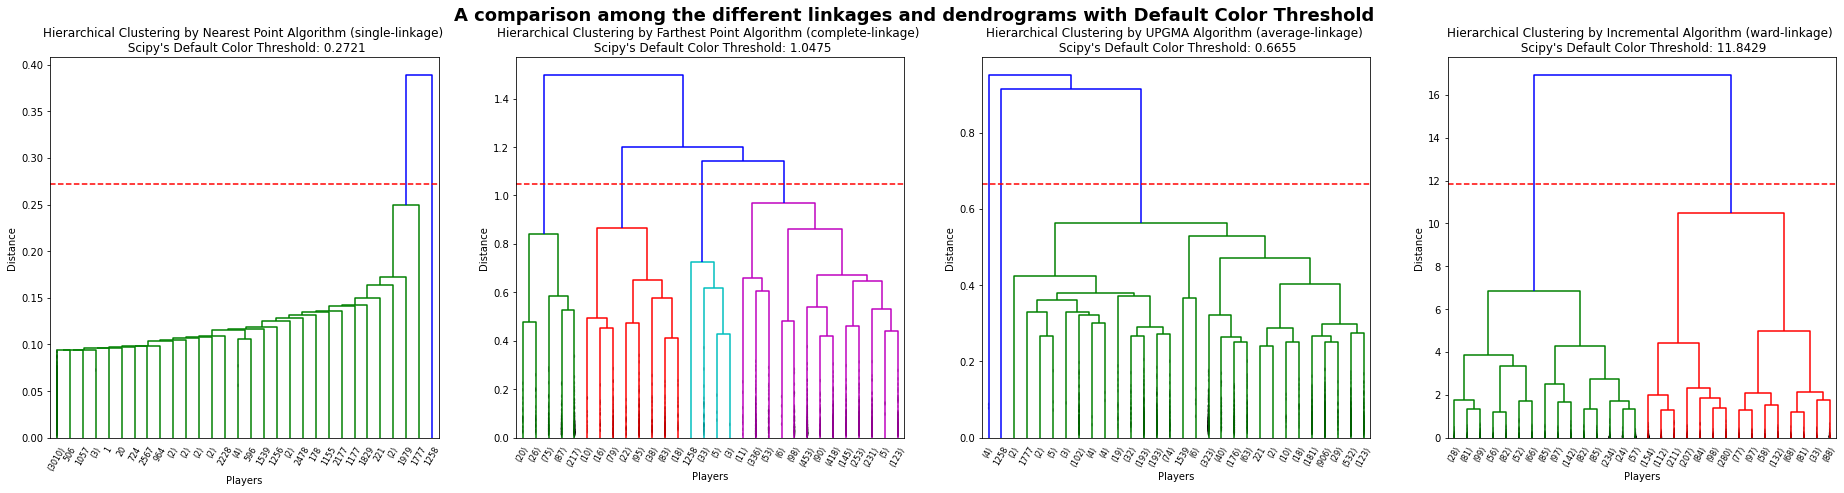

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist

methods = ['single', 'complete', 'average', 'ward']
from sklearn.cluster import AgglomerativeClustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
#we compute the heght of the cut suggested by the default color_threshold
defaults_color_thresholds = []
cs_norm_minmax=scaled
for method in methods:
    Z = linkage(cs_norm_minmax, method)
    defaults_color_thresholds.append(0.7*max(Z[:,2]))
# We plot the four dendrograms
algorithms = ['Nearest Point', 'Farthest Point', 'UPGMA', 'Incremental']
hierarchical_models = []
hierarchical_models_old = []
f, axs = plt.subplots(ncols=4, figsize=(32,7))

for i in range(len(methods)):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(cs_norm_minmax) 
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[i])
    hierarchical_models.append(model)
    hierarchical_models_old.append(model)

    axs[i].set_title('Hierarchical Clustering by ' + algorithms[i] + ' Algorithm (' + methods[i] + '-linkage) \n Scipy\'s Default Color Threshold: ' + '{:2.4f}'.format(defaults_color_thresholds[i]))
    axs[i].set_xlabel('Players')
    axs[i].set_ylabel('Distance')
    axs[i].axhline(defaults_color_thresholds[i], ls='--', color='r')

plt.suptitle(('A comparison among the different linkages and dendrograms with Default Color Threshold'),
             fontsize=18, fontweight='bold')
plt.show()

We define a function to identify the height of the optimal cut within a dendrogram. It works by iteratively cutting the tree at an height increased at each step. Each cut returns the given number of clusters identified by the structure under the cut and, by calculating the value for the number of clusters suggested by the greater number of cuts, we can identify the longest uninterrupted vertical segment of the dendrogram.

The function takes in input:

- the linkage-method to utilize in order to compute the proximity among the nodes
- the step to utilize to increase the height of the cuts at each iteration and
- the data for which we want to perform the clustering.

Performed analysis for single-linkage: reached n_clusters = 1 in 390 steps
Performed analysis for complete-linkage: reached n_clusters = 1 in 151 steps
Performed analysis for average-linkage: reached n_clusters = 1 in 97 steps
Performed analysis for ward-linkage: reached n_clusters = 1 in 171 steps


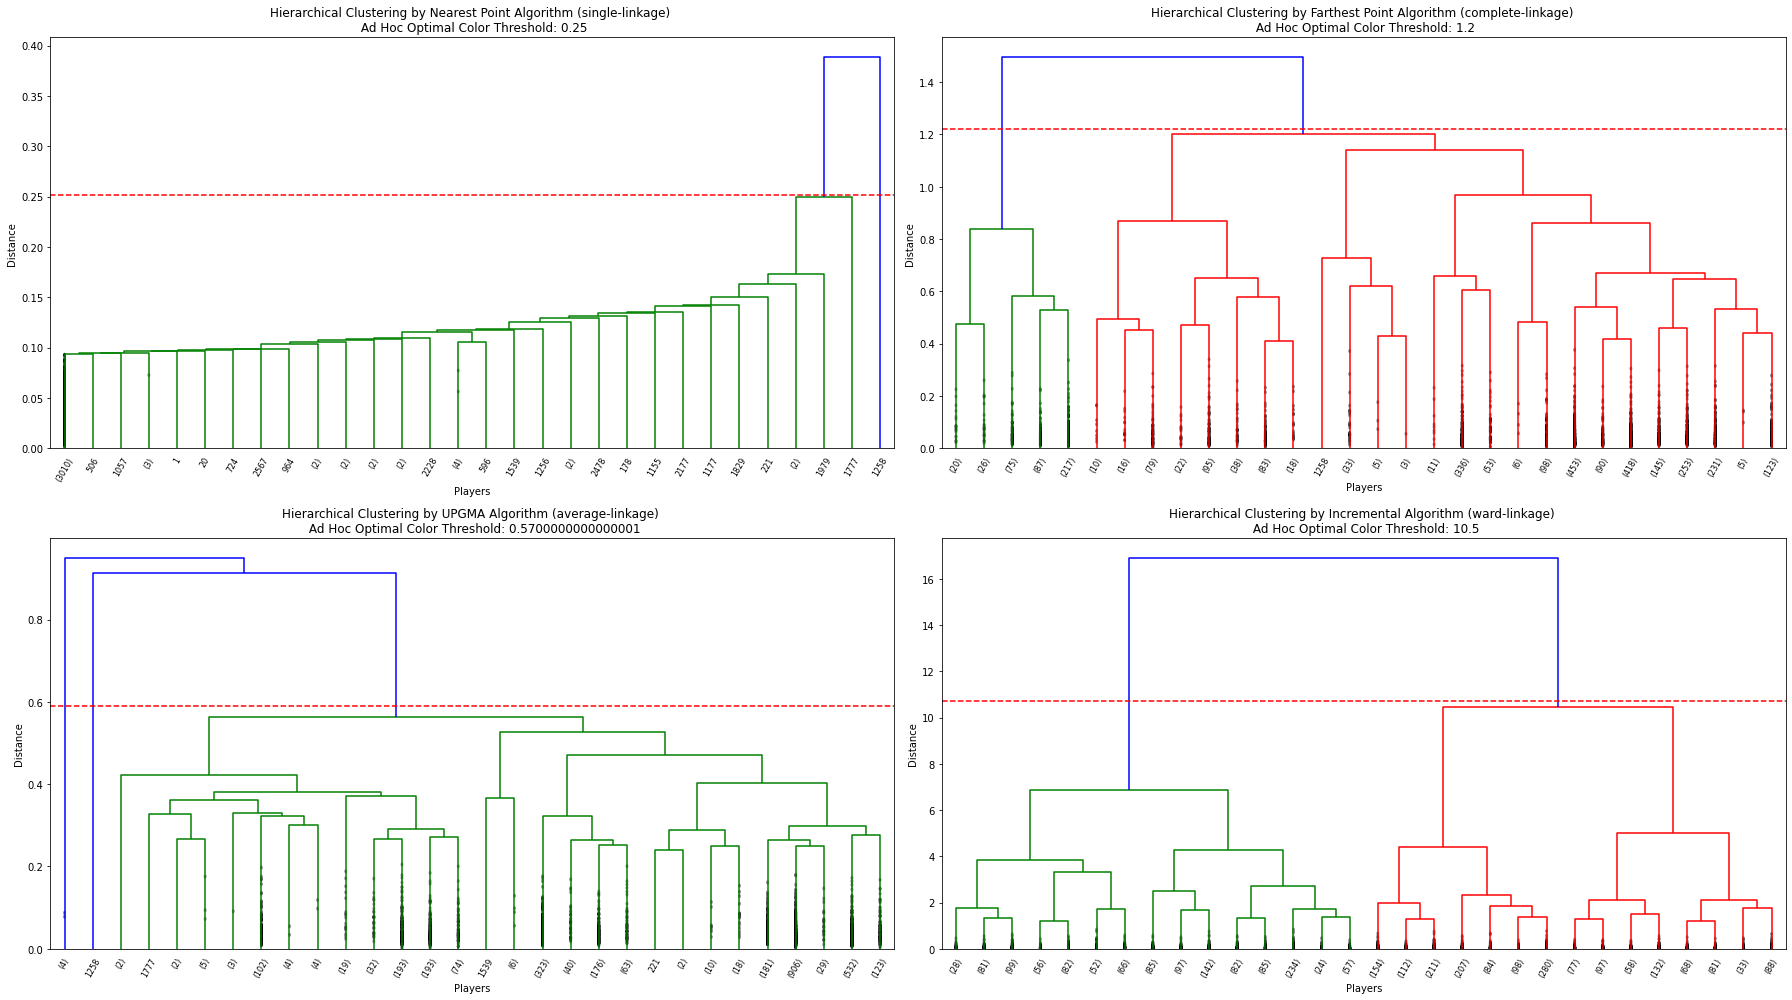

In [ ]:
def get_best_cut(linkage, step, norm_dataframe):
    store_n_clusters = []
    store_distances = []

    n_clusters = 0
    i = 0

    while n_clusters != 1:
        distance_threshold = i*step
        model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None, affinity='euclidean', linkage=linkage).fit(norm_dataframe)
        i = i + 1

        n_clusters = model.n_clusters_
        store_distances.append(distance_threshold)
        store_n_clusters.append(n_clusters)

    df = pd.DataFrame()

    df['distance_thresholds'] = store_distances
    df['n_clusters'] = store_n_clusters
    
    df_n_clusters_groups = df.groupby('n_clusters').size()
    
    n_for_opt_cut = df_n_clusters_groups.agg(['idxmax'])[0]
    distance = df[df.n_clusters == n_for_opt_cut].distance_thresholds.min()
    
    print('Performed analysis for ' + linkage + '-linkage: reached n_clusters = 1 in ' + str(i) + ' steps')
    #print('OPT: Dist = ' + str(distance) + ', n_clusters = ' + str(n_for_opt_cut))     
    
    return n_for_opt_cut, distance
steps = [0.001, 0.01, 0.01, 0.1]

opt_n_clusters = []
heights = []

for i in range(len(methods)):
    n_for_opt_cut, height = get_best_cut(methods[i], steps[i], cs_norm_minmax)
    opt_n_clusters.append(n_for_opt_cut)
    heights.append(height)
    
hierarchical_distances = pd.DataFrame()
hierarchical_distances['method'] = methods
hierarchical_distances['n_clusters_for_best_cut'] = opt_n_clusters
hierarchical_distances['height'] = heights
hierarchical_distances.set_index(['method'], inplace=True)

hierarchical_distances

# We plot the four dendrograms
algorithms = ['Nearest Point', 'Farthest Point', 'UPGMA', 'Incremental']
hierarchical_models = []

f, axs = plt.subplots(2,2, figsize=(25,14))
clusters_labels = []
for i in range(len(methods)):
    color_threshold = hierarchical_distances.loc[methods[i]].height
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', linkage=methods[i]).fit(cs_norm_minmax) 
    clusters_labels.append(model.labels_)
    plot_dendrogram(model, truncate_mode='lastp', p=30, leaf_rotation=60, leaf_font_size = 8, show_contracted=True, ax=axs[math.floor(i/2)][(i%2)], color_threshold=color_threshold)
    hierarchical_models.append(model)
    
    axs[math.floor(i/2)][(i%2)].set_title('Hierarchical Clustering by ' + algorithms[i] + ' Algorithm (' + methods[i] + '-linkage) \n Ad Hoc Optimal Color Threshold: ' + str(color_threshold))
    axs[math.floor(i/2)][(i%2)].set_xlabel('Players')
    axs[math.floor(i/2)][(i%2)].set_ylabel('Distance')
    axs[math.floor(i/2)][(i%2)].axhline(color_threshold + steps[i]*2, ls='--', color='r')

plt.tight_layout()
f.savefig('hierarchical.png')
plt.show()

In [ ]:
hierarchical_distances

,n_clusters_for_best_cut,height
method,,
single,2,0.25
complete,2,1.20
average,3,0.57
ward,2,10.50


single silhouette: 0.5480436670820548
Clusters labels: [0 1]
Elements per cluster: [3049    1]


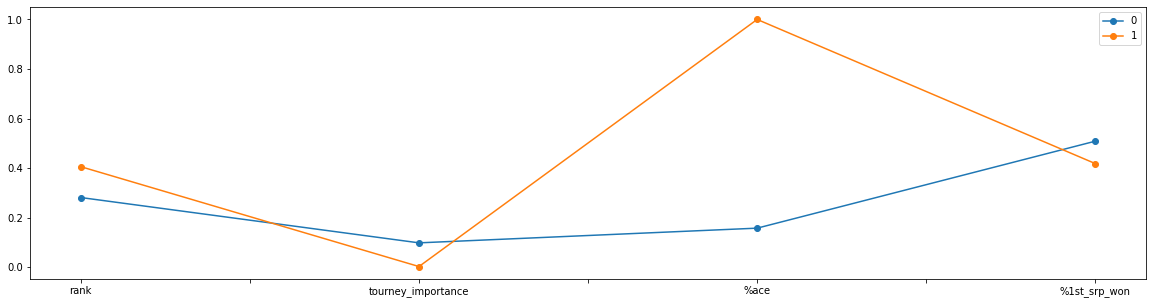

complete silhouette: 0.3807471212260408
Clusters labels: [0 1]
Elements per cluster: [2625  425]


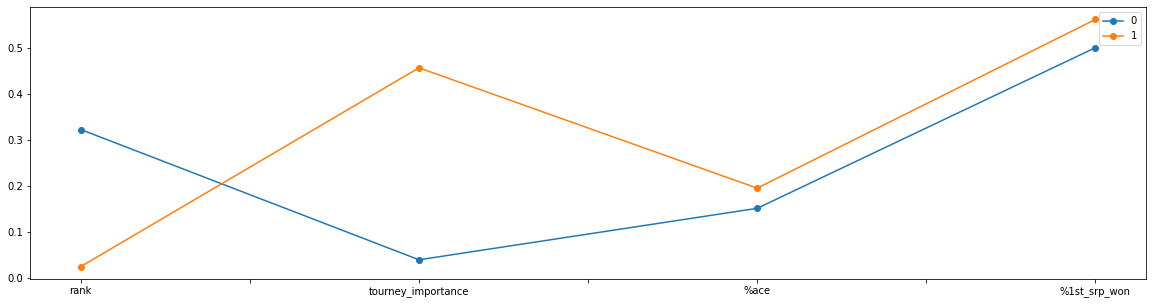

average silhouette: 0.47403691471982196
Clusters labels: [0 1 2]
Elements per cluster: [3045    4    1]


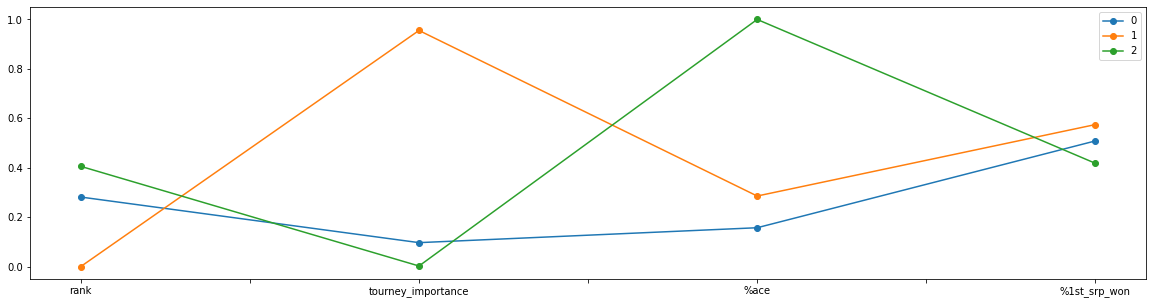

ward silhouette: 0.37796900589766963
Clusters labels: [0 1]
Elements per cluster: [1780 1270]


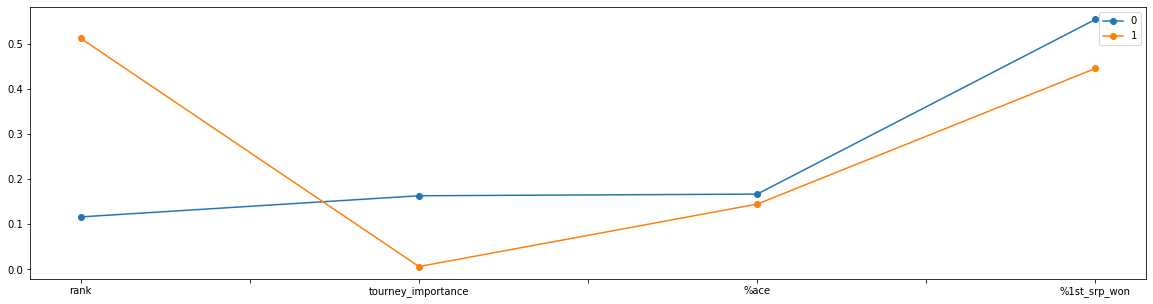

In [ ]:
from sklearn.cluster import AgglomerativeClustering
linkage = ['single', 'complete', 'average', 'ward']
vals = hierarchical_distances['height'].values
all_labels = []
for i in range(0,4):
  aggl_clust = AgglomerativeClustering(distance_threshold=vals[i], n_clusters=None, affinity='euclidean', linkage=linkage[i]).fit(cs_norm_minmax)
  if(np.unique(aggl_clust.labels_).shape[0]> 1):
    print(linkage[i]+" silhouette: "+str(silhouette_score(scaled, aggl_clust.labels_)))
    all_labels.append(aggl_clust.labels_)
    results = np.unique(aggl_clust.labels_, return_counts=True)
    print(f"Clusters labels: {results[0]}\nElements per cluster: {results[1]}")
    local = pd.DataFrame(scaled, columns=correct_columns.columns[:-1]) # single
    local['cluster'] = aggl_clust.labels_
    local = local.groupby('cluster').mean().reset_index()
    local.iloc[:, 1:].transpose().plot(figsize=(20,5),marker='o')
    plt.legend(np.sort(local['cluster'].unique()));
    plt.show()
  else:
    all_labels.append([])
    print(linkage[i]+" only one cluster\n")

From the dendograms and the result previously shown, the first three methods are not able to create a good and balanced clustering, all the items are collapsed in a singularbig cluster. With Ward’s method, instead, the result is more balanced, and it is possibleto study a characterization of the elements inside the two main clusters. The results aresimilar to the ones obtained from K-Means in witch the clusters seem to represent thedifferent types of players very strong player and weak one.

# New Clustering models

In this part we tried alternative clustering techniques in the library  https://github.com/annoviko/pyclustering/  
We tried 2 algorithms:
- X-means:
- Fuzzy K-means:

In [ ]:
!pip install pyclustering

     |████████████████████████████████| 2.6 MB 11.7 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=47de0ba394ca765bce03386122d96baa55c9247c97d37575450190ad3f9f787a
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


## X-means

K-means suffer three major shortcomings: it scales poorly computationally, the number of cluster K has to be supplied by the user, and the search is prone to local minima. **X-means** approach solve the first two problems by alternatively applying two operations:
- The K-Means algorithm (Improve-params) to optimally detect the clusters for a chosen value of k
- Cluster splitting(Improve-structure) to optimize the value of k according to Information Criterion. In this method, the actual value of K is estimated in a way that is not monitored and only based on the data set.

We set that the initial centroid are 2 so it start from 2 clusters and the maximum number of clusters that can be allocated is 20

In [ ]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES

initial_centers = kmeans_plusplus_initializer(scaled, 2).initialize()
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(scaled, initial_centers, 20)
xmeans_instance.process()
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

Size inside each cluster:
3.0     386
4.0     372
0.0     356
11.0    316
13.0    290
1.0     222
7.0     185
6.0     173
5.0     162
8.0     140
12.0    133
2.0     131
10.0    124
9.0      60
Name: cluster, dtype: int64


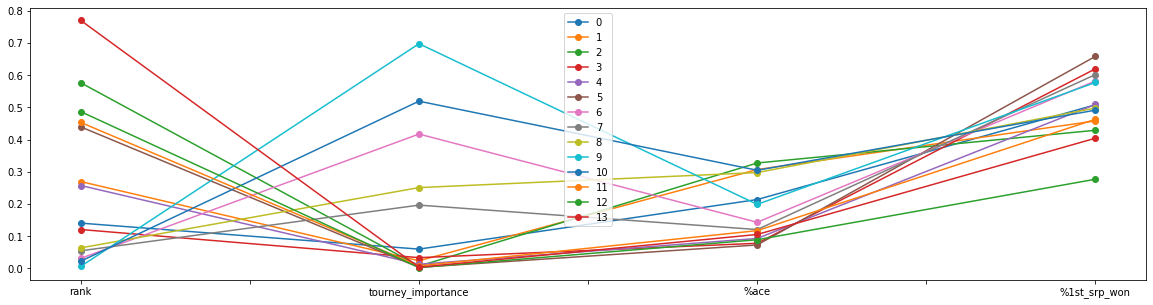

Cluster 0.0 avg silhouette: 0.25778008336819314
Cluster 1.0 avg silhouette: 0.1962419090159746
Cluster 2.0 avg silhouette: 0.1763880190136883
Cluster 3.0 avg silhouette: 0.3071802271446753
Cluster 4.0 avg silhouette: 0.24456481248359044
Cluster 5.0 avg silhouette: 0.1739472748013351
Cluster 6.0 avg silhouette: 0.29079933649045264
Cluster 7.0 avg silhouette: 0.2880608071774406
Cluster 8.0 avg silhouette: 0.2620235683224335
Cluster 9.0 avg silhouette: 0.25889709445740533
Cluster 10.0 avg silhouette: 0.3049235796273502
Cluster 11.0 avg silhouette: 0.250245925581916
Cluster 12.0 avg silhouette: 0.2045837014832968
Cluster 13.0 avg silhouette: 0.27477151081519385
Total avg silhouette: 0.2543507039264244


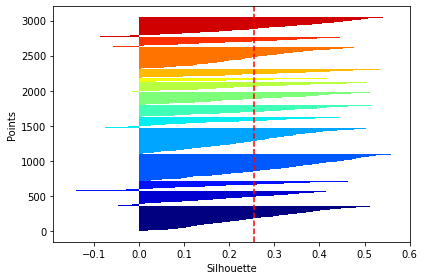

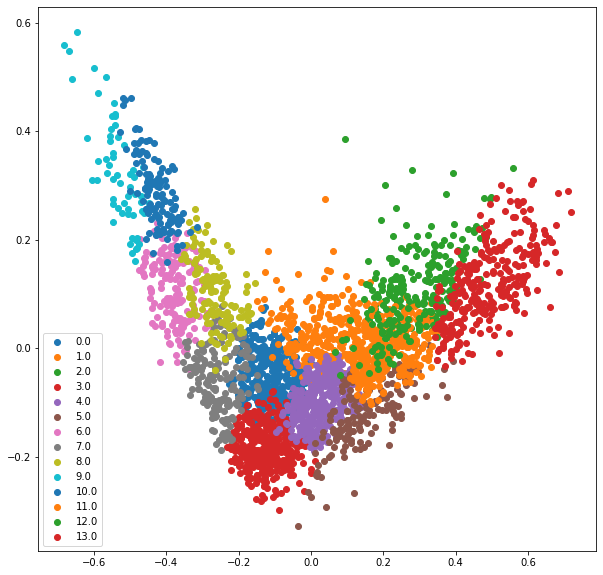

In [ ]:
xmeans_scaled = pd.DataFrame(scaled, columns=correct_columns.columns)
for cluster_num, cluster_list in enumerate(clusters):
  for index in cluster_list:
    xmeans_scaled.loc[index,'cluster'] = cluster_num

print("Size inside each cluster:")
print(xmeans_scaled.cluster.value_counts())
xmeans_centroids = xmeans_scaled.groupby('cluster').mean().reset_index()
xmeans_centroids.iloc[:, 1:].transpose().plot(figsize=(20,5),marker='o')
plt.show()
plot_silhouette_score(scaled,xmeans_scaled.cluster.values)
plt.show()

label = xmeans_scaled.cluster.values
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(principalComponents[label == i, 0] , principalComponents[label == i, 1] , label = i)
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()

The results obtained with x-means are totally different from the previous approaches, in this case the algorithm managed to find 15 clusters. with a silhouette score of 0.25. Through the line graph we can see that each feature is layered on the clusters. In this way, having more groups we can see the internal differences between the strongest, average and poor players who differ in some specific features.

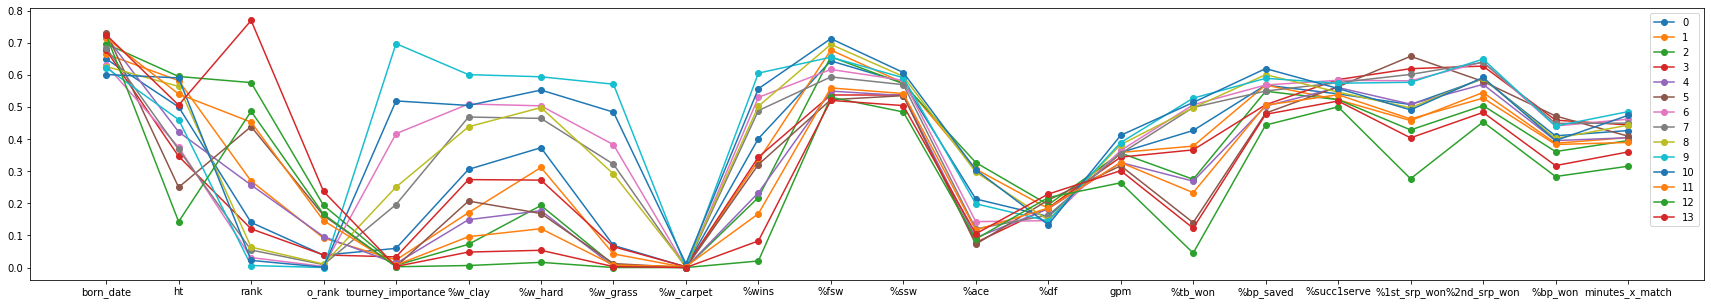

In [ ]:
prova = players[:]
prova = prova[(prova['rank'].notna())] #taking columns with rank
prova = prova[(prova['o_rank'].notna())] #taking columns with o_rank
prova = prova.drop(['gender','id','ioc','hand', 'mean_tourney_importance'],axis=1)
prova_scaled = scaler.fit_transform(prova.values)
prova_scaled = pd.DataFrame(prova_scaled, columns=prova.columns)
prova_scaled['cluster'] = xmeans_scaled['cluster']
ax = prova_scaled.groupby('cluster').mean().reset_index().iloc[:, 1:].transpose().plot(figsize=(30,5),marker='o')
ax.set_xticks(range(0, prova_scaled.columns[:-1].shape[0]))
ax.set_xticklabels(prova_scaled.columns[:-1])
plt.show()

## Fuzzy-C-means

Fuzzy-C-means is a clustering algorithm based on fuzzy logic. In particular, a point is not forced to belong to a cluster or to another because through the fuzzy logic, data points can potentially belong to multiple clusters with a value that goes from 0 to 1. The fuzzy c-means algorithm is very similar to the k-means algorithm and it differ by the membership values in the objective function and the fuzzifier value m. The fuzzifier m determines the level of cluster fuzziness. A large m results in smaller membership values and hence, fuzzier clusters. When m is set to 1 the membership converge to 0 o 1 resulting in a crisp partitioning. In absence of knoledge of the domain the default value is set to to 2. The algorithm minimizes intra-cluster variance as well, but has the same problems as 'k'-means; the minimum is a local minimum, and the results depend on the initial choice of weights.  
We use the same hyper-parameter K=3 found in the k-means approach in order to compare the two algorithms.


Size inside each cluster:
2.0    1548
0.0     906
1.0     596
Name: cluster, dtype: int64


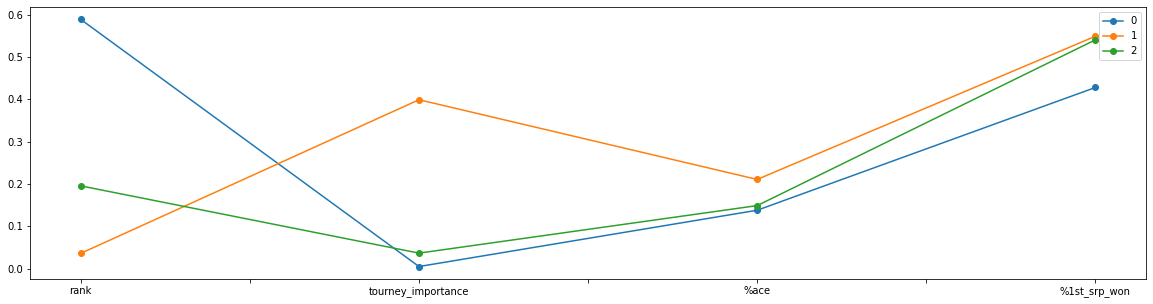

Cluster 0.0 avg silhouette: 0.3347099716288501
Cluster 1.0 avg silhouette: 0.3885288871050155
Cluster 2.0 avg silhouette: 0.4296925565790798
Total avg silhouette: 0.3934342716704075


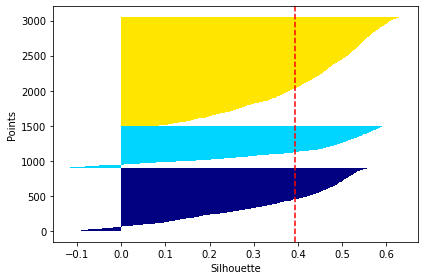

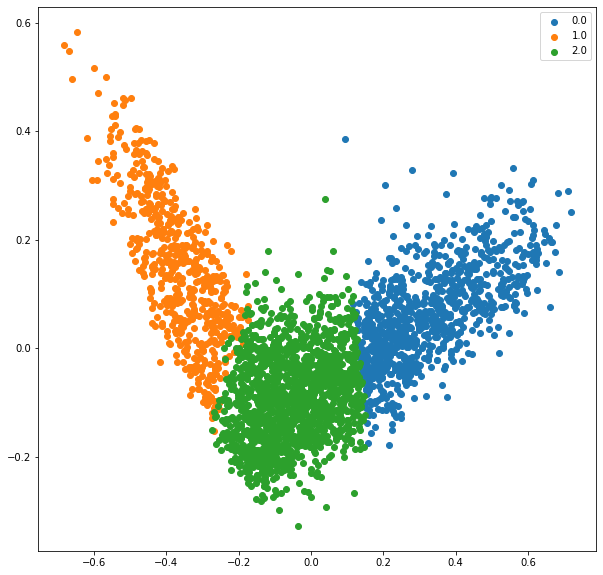

In [ ]:
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
from pyclustering.utils import read_sample
# initialize
initial_centers = kmeans_plusplus_initializer(scaled, 3, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(scaled, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

fuzzykmeans_scaled = pd.DataFrame(scaled, columns=correct_columns.columns)
for cluster_num, cluster_list in enumerate(clusters):
  for index in cluster_list:
    fuzzykmeans_scaled.loc[index,'cluster'] = cluster_num

print("Size inside each cluster:")
print(fuzzykmeans_scaled.cluster.value_counts())
xmeans_centroids = fuzzykmeans_scaled.groupby('cluster').mean().reset_index()
xmeans_centroids.iloc[:, 1:].transpose().plot(figsize=(20,5),marker='o')
plt.show()
plot_silhouette_score(scaled,fuzzykmeans_scaled.cluster.values)
plt.show()

label = fuzzykmeans_scaled.cluster.values
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(principalComponents[label == i, 0] , principalComponents[label == i, 1] , label = i)
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()

The results obtained are in line with our estimate, the two algorithms provide similarresults. We see how in the line plot. the three clusters represent the skill of the playersstrong player, medium player and weak player.  The main difference we can see is adifference in the silhouette score due to the different size of the three clusters. This is caused by the fact that through fuzziness we can have a different distribution of datapoints where a point can belong to more clusters but at the end each cluster containspoints that most likely (in line with membership) belong to that cluster.